# Interpretable and accessible Deep Learning for omics data with R and friends
Moritz Hess, Stefan Lenz, Harald Binder

Institute of Medical Biometry and Statistics
Faculty of Medicine and Medical Center - University of Freiburg


## About
Here we perform the analyses as presented in our talk at the e-eRUM 2020. Our aim is:

1. to show how generative deep generative models in combination with log-linear models can be employed to extract meaningful patterns from single cell (sc) RNA-Seq data

2. to demonstrate the ease with which algorithms implemented in the programming language [Julia](julialang.org) can be leveraged for accessible deep learning applications in R.

Specifically [deep Boltzmann machines (DBMs)](http://www.cs.toronto.edu/~fritz/absps/dbm.pdf), which are deep generative models, are employed for learning the joint distribution of the observed variables (the genes; $x$) and latent variables (in $u$ and $h_{1}$), capturing non-linear dependencies in the data ($X$). 
![dbm_joint.png](dbm_joint.png)
This joint distribution is then investigated with log-linear models to infer joint patterns between the states of a subset of the latent variables ($U^{syn}$) and observed variables ($X^{syn}$), sampled from a trained DBM (examples for $U^{syn}$ and $X^{syn}$ are shown on the right-hand of the figure).

The software to train DBMs [BoltzmannMachines.jl](https://github.com/stefan-m-lenz/BoltzmannMachines.jl) and to fit log-linear models was implemented in Julia for [speed reasons](https://julialang.org/benchmarks/). The [JuliaConnectorR](https://github.com/stefan-m-lenz/JuliaConnectoR) is employed for rendering the above stated functionalities accessible in R.  

## Load and process the RNA-Seq data using R functionality
First, we need to load the expression data using R. We use publically available scRNA-Seq data, published by [Tasic et al. (2016)](https://www.nature.com/articles/nn.4216) and we employ standard R functions. 

In [1]:
URL = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE71nnn/GSE71585/suppl/GSE71585%5FRefSeq%5Fcounts%2Ecsv%2Egz" 
download.file(URL,"GSE71585.csv.gz")
gex = read.csv("GSE71585.csv.gz",stringsAsFactors=FALSE,row.names=1)
gex = data.matrix(gex)
gex = round(gex)

Then, we install and load R packages, needed for plotting and processing the data. 

In [2]:
install.packages("openxlsx")
install.packages("gplots")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq")
BiocManager::install("org.Mm.eg.db")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.1 (2020-06-06)

Installing package(s) 'DESeq'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'survival'

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.1 (2020-06-06)

Installing package(s) 'org.Mm.eg.db'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'survival'



In [3]:
library(openxlsx)
library("org.Mm.eg.db")
library(DESeq)
library(gplots)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: Biobase

We then define a color scheme for later plotting.

In [4]:
colmap = list(
"Vip"="#9900CC",
"Sst"="#FFCC00",
"Pvalb"="#FF3300",
"L4"="#0099FF",
"L5b"="#009900",
"L2"="#999999",
"Ndnf"="#999999",
"L5a"="#999999", 
"L5"="#999999",  
"L6b"="#999999", 
"Sncg"="#999999",
"Igtp"="#999999",
"Smad3"="#999999",
"L6a"="#999999",
"OPC"="#999999",
"Oligo"="#999999",
"Endo"="#999999",
"Micro"="#999999",
"Smad3"="#999999",
"Astro"="#999999",
"SMC"="#999999",
"L2/3"="#999999"
)

We load the information about the samples and an annotation package for *Mus musculus*.

In [5]:
sampleinfo <- readWorkbook("nn.4216-S5.xlsx",sheet=1,rowNames=FALSE)
sampleinfo$GEO.Sample.Title = gsub("-",".",sampleinfo$GEO.Sample.Title,fixed=TRUE)
annokeys = keys(org.Mm.eg.db,keytype="MGI")
annot= select(org.Mm.eg.db,keys=annokeys,columns=c("SYMBOL","GENENAME"),keytype="MGI")

'select()' returned 1:1 mapping between keys and columns



We  restrict the expression to annotated samples and extract the celltype information.

In [6]:
gex = gex[,sampleinfo$GEO.Sample.Title]
celltype <- gsub("(.*?) .*","\\1",sampleinfo$Primary.Type)

We then normalize for sequencing depth using DESeq.

In [7]:
DESeq. <- newCountDataSet(gex,conditions = rep(1,ncol(gex)))
DESeq. <- estimateSizeFactors(DESeq.)
Norm.Fact <- matrix(rep(DESeq.@phenoData@data$sizeFactor,nrow(gex)),nrow=nrow(gex),byrow = TRUE)
Counts.Norm <- t(t(gex)) / Norm.Fact

We load lists of interesting genes, as flagged by domain experts. These genes are also published in [Tasic et al. (2016)](https://www.nature.com/articles/nn.4216).

In [8]:
markergenes = read.csv("gene_subtypes.csv",sep=";")[,1]
receptorgenes = read.delim("S15.txt",header=FALSE,sep=" ")
receptorgenes = unique(unlist(receptorgenes))

And we also identify the non-neural cells in the data-set which we want to exclude before modeling.

In [9]:
NonNeural = c("Astro Aqp4","OPC Pdgfra","Oligo 96*Rik","Oligo Opalin","Micro Ctss","Endo Xdh","SMC Myl9")
neuralcells = !(sampleinfo$Primary.Type %in% NonNeural)

Finally we restrict the celltype label and the expression data to only neural cells and the pre-selected gene-set.

In [10]:
selected_genes = markergenes
celltype = celltype[neuralcells]
x = t(Counts.Norm[rownames(Counts.Norm) %in% selected_genes,neuralcells])

We then inspect the selected data

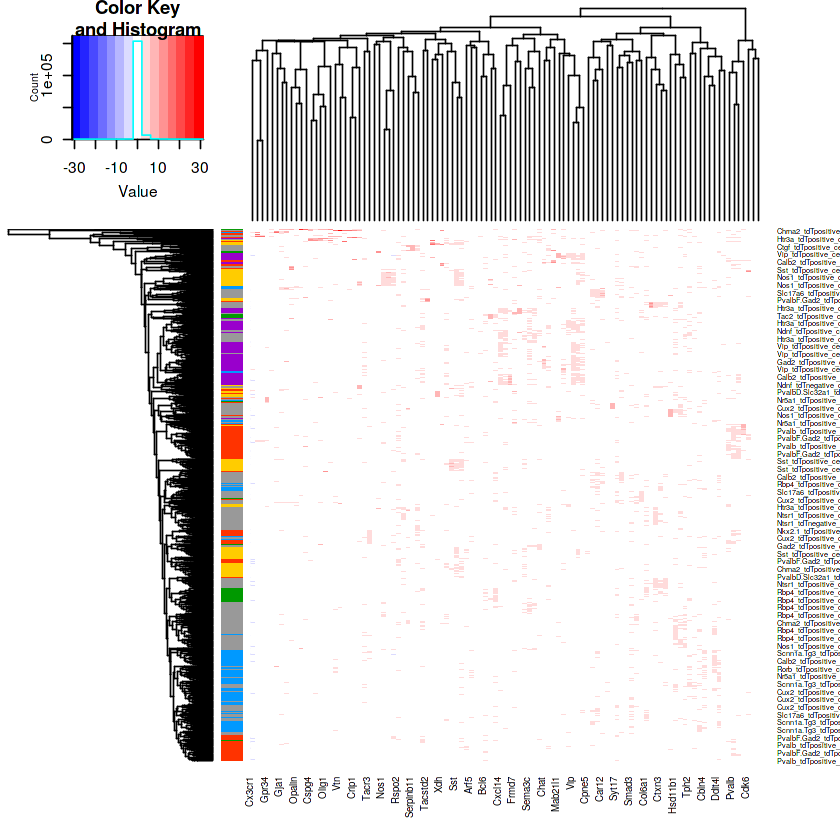

In [11]:
samplecol = unlist(colmap[celltype])
# pdf("expression_data_modeled.pdf",height=10,width=6)
heatmap.2(scale(log(x+1)),RowSideColors=samplecol,trace="none",col=bluered)
# dev.off()

For modeling, we dichotomize the expression data ...

In [12]:
x01 = apply(x,2,function(y) ifelse(y > median(y),1,0))

... and again inspect the transformed data.

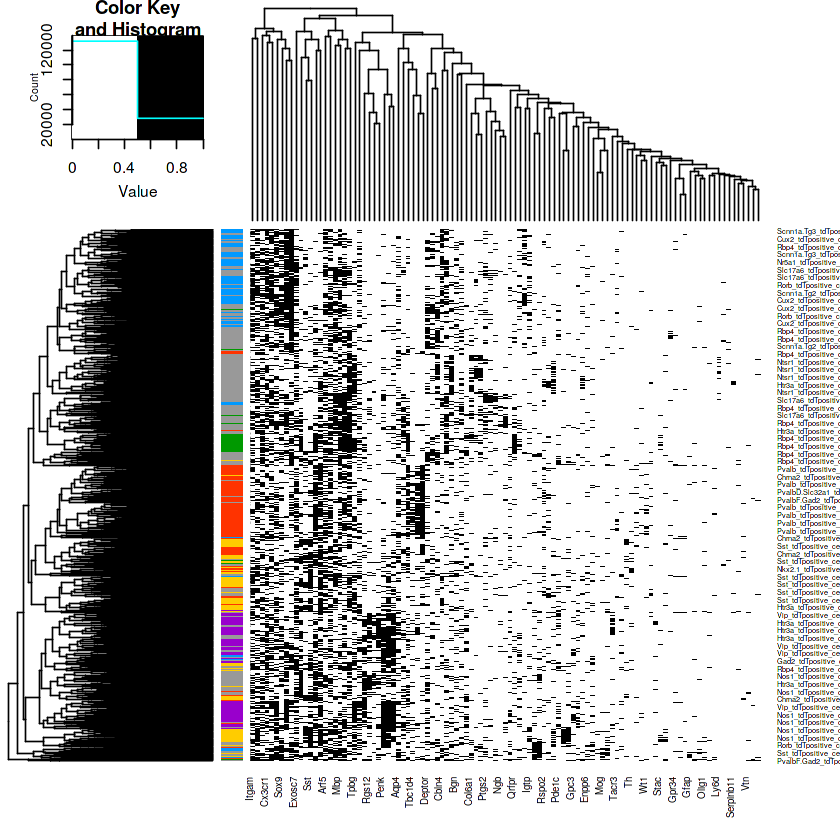

In [13]:
# pdf("expression_data_modeled_binary.pdf",height=10,width=6)
heatmap.2(x01,RowSideColors=samplecol,trace="none",col=c("white","black"))
# dev.off()

## Extract information carrying genes with deep Boltzmann machines and log-linear models using Julia and the JuliaConnectoR
We now employ deep-learning techniques and techniques to extract information from trained models. Specifically, we employ deep generative methods, such as DBMs which learn the joint distribution in the data. I.e. we are dealing with unsupervised techniques. From a trained DBM we generate synthetic data for observed and latent variables. Based on joint patterns between latent variables and observed variables, we infer the information carrying observed variables. All employed methods are implemented in Julia for sake of speed. To employ these in R, we employ the [JuliaConnectoR](https://cran.r-project.org/web/packages/JuliaConnectoR/index.html), written by [Stefan Lenz](https://github.com/stefan-m-lenz).
We start by loading the JuliaConnectoR R package. We can then install the needed Julia packages. Since we provide a pre-configured Julia environment here, these packages are automatically installed.

In [14]:
install.packages("JuliaConnectoR")
library(JuliaConnectoR)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [15]:
# juliaEval('Pkg.add(Pkg.PackageSpec(;name="Flux", version="0.9"))')
# juliaEval('Pkg.add("BoltzmannMachines")')
# juliaEval('Pkg.add(PackageSpec(url="https://github.com/ssehztirom/LogLinearModels.jl"))')
# juliaEval('Pkg.add(PackageSpec(url="https://github.com/ssehztirom/PatternsByLogLin.jl"))')
juliaEval('using Pkg')
juliaEval('Pkg.activate(".")')
juliaEval('Pkg.instantiate()')

# Set a random seed in Julia
juliaEval("using Random; Random.seed!(5);")
BM <- juliaImport("BoltzmannMachines")
juliaEval('using LogLinearModels')
PatternExtractor <- juliaImport("PatternsByLogLin")

Starting Julia ...



We define some convenience functions for easier investigation of the trained DBMs.

In [16]:
get_weights = function(dbm,weights=1)
{
	return(juliaLet('x[weightnumber].weights',x = dbm,weightnumber = weights))
}

sample_visible_hidden = function(dbm,num_samples=100L)
{
	particles <- BM$initparticles(dbm, num_samples)
	particles <- BM$gibbssample(particles, dbm, 100L)
	visible = juliaLet('x[1]',x = particles)
	hidden = juliaLet('x[end]',x = particles)
	return(list(visible = visible, hidden = hidden))
}

We then train DBMs on the gene expression data ...

In [17]:
dbm <- BM$fitdbm(x01, epochs = 10L, learningrates = rep(0.05, 10),epochspretraining=200L,learningratepretraining=0.001,
                 nhiddens = c(100L,10L))

... and sample synthetic observations for the terminal latent variables and the observed variables, representing the genes.

In [18]:
synth_x= sample_visible_hidden(dbm,10000L)

Using log-linear models, we now infer the observed variables, i.e. the genes whose states form joint patterns with the states of latent variables. Combinations of states of these variables are patterns that should contain the essential information in the dataset with respect to the identity of cell populations. We aim at selecting ```num_select``` genes.

In [19]:
num_select = 8L
visiblefeatures = PatternExtractor$bestset(num_select,synth_x$visible,synth_x$hidden,verbose=TRUE)

[8]
[8, 69]
[8, 69, 77]
[8, 69, 77, 10]
[8, 69, 77, 10, 87]
[8, 69, 77, 10, 87, 13]
[8, 69, 77, 10, 87, 13, 102]
[8, 69, 77, 10, 87, 13, 102, 43]


We then check, which genes have been selected.

In [20]:
colnames(x01)[visiblefeatures]

[1] "Calb2" "Penk"  "Rorb"  "Car4"  "Sst"   "Cdh13" "Vip"   "Gria3"

## Annotate synthetic observations by training data using the selected observed variables.
Since the selected variables should contain the essential information in the dataset with respect to cell populations, we should be able to annotate synthetic cells, generated by the DBM, based on patterns in the selected variables. We perform this operation completely in R.
![annotate_by_pattern.png](annotate_by_pattern.png)

In [21]:
matrix_to_codelist = function(matrix)
{
	xy.list <- split(matrix, seq(nrow(matrix)))
	return(lapply(xy.list, function(x) paste(x,collapse="")))
}

annotate_samples_by_pattern = function(x,y,x_synth,patternpos)
{
	codes_x =x[,patternpos]
	codes_x_synth = x_synth[,patternpos]
	codelist_x = matrix_to_codelist(codes_x)
	codelist_x_synth = unlist(matrix_to_codelist(codes_x_synth))
	x_to_y=as.list(y)
	names(x_to_y)=unlist(codelist_x)
	annotated = x_to_y[codelist_x_synth]
	not_annotated = unlist(lapply(annotated,is.null))
	num_not_annotated = sum(unlist(not_annotated))
	random_labels = ceiling(runif(num_not_annotated)*length(unique(y)))
	annotated[not_annotated] = unique(y)[random_labels]
	print(sprintf("%s synthetic observations without label",num_not_annotated))
	return(unlist(annotated))
}

We now annotate 1000 synthetic observations, based on the identified pattern, using the training data.

In [22]:
x_synth = sample_visible_hidden(dbm,1000L)$visible
y_synth = annotate_samples_by_pattern(x01,celltype,x_synth,visiblefeatures)

[1] "33 synthetic observations without label"


Let's have a look at the data! We compare the annotation of the synthetic data with the original expression data. For this purpose, we jointly standardize the synthetic observations with the training data and then plot the set of synthetic and real observations.

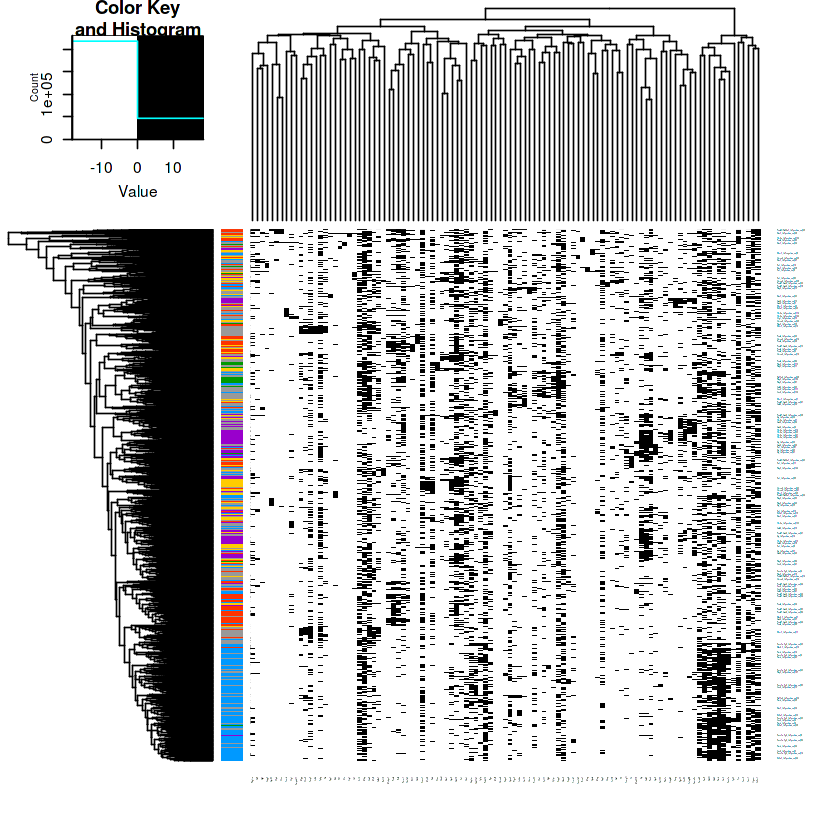

In [23]:
x_x_synth = scale(rbind(scale(x01),scale(x_synth)))
y_y_synth = c(unlist(colmap[celltype]),unlist(colmap[y_synth]))
# pdf("original_and_synth.pdf",width=7,height=12)
heatmap.2(x_x_synth,trace="none",col=c("white","black"),RowSideColors=y_y_synth,cexCol=0.1,cexRow=0.1)
# dev.off()


To allow for an easier comparison of synthetic with real observations, we reduce the dimensionality of the set, e.g. by extracting the principal components (PCs) from the joint set. Afterwards, we visually inspect, to what extent synthetic observations with a given annotation are in the proximity of the original data example from which the label has been transferred. I.e. we check if synthetic observations in a region of the plot have the same color as the training data in this region.

In [24]:
x_x_synth = prcomp(scale(rbind(x01,x_synth)))$x[,1:2]
x_scale = x_x_synth[1:nrow(x01),]
x_synth_scale = x_x_synth[(nrow(x01)+1):nrow(x_x_synth),]


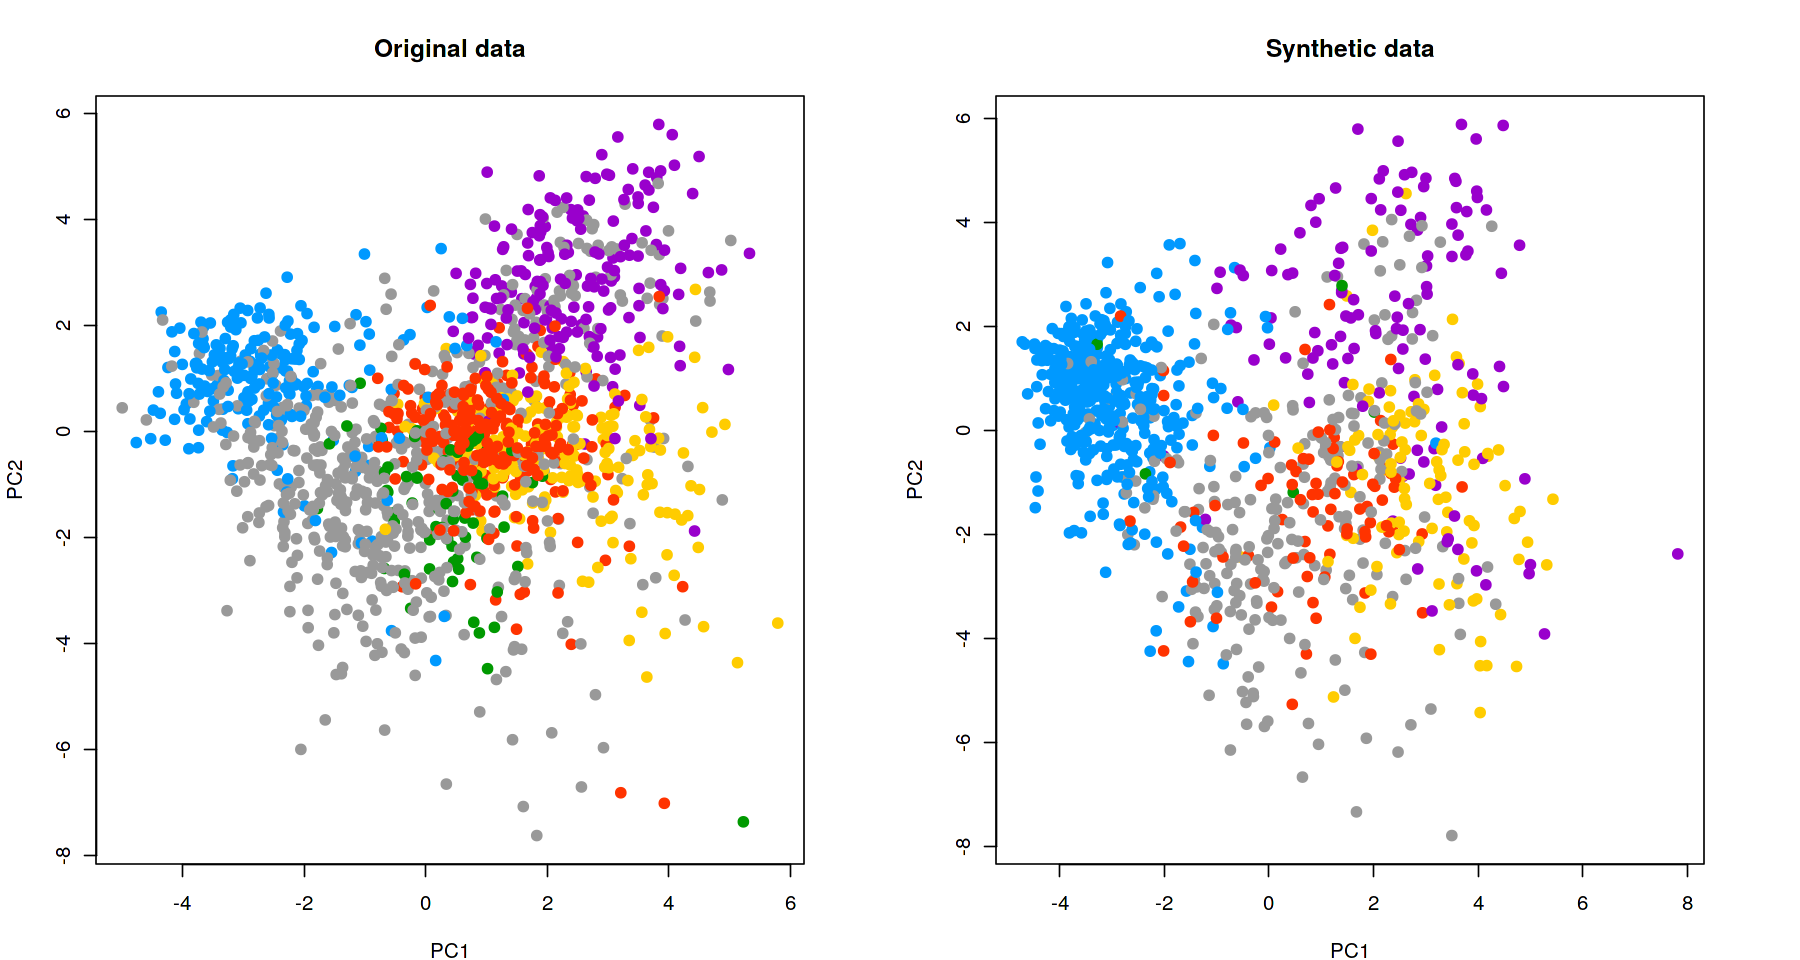

In [25]:
options(repr.plot.width=15, repr.plot.height=8)
par(mfrow = c(1,2),mar=c(4,4,4,4))
plot(x_scale,col=unlist(colmap[celltype]),pch=19,main="Original data")
plot(x_synth_scale,col=unlist(colmap[y_synth]),pch=19,main="Synthetic data")
# dev.off()

We see, that the synthetic data carrying a given label is located in the same area where the original data with the same label is located. This indicates that we extracted the genes which are relevant for cell identity.